# Goal:

Continue to try to explain this:

<img src="MeanXvsY.png" alt="Sample Image" width="500">

Specifically, we want to look for what "inside" the X values might affect Flood Probability the most

1. look at the outliers
2. try fixing some combination of X variables, and see how deviating another variable affects things
3. try guessing 1-NN, and then adding a constant based on the distance

# 1. Look at Outliers

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.neighbors import KNeighborsRegressor

In [22]:
DIRECTORY = './data/'
train = pd.read_csv(DIRECTORY + 'train.csv').drop(columns='id')
test = pd.read_csv(DIRECTORY + 'test.csv').drop(columns='id')

1 [0.64684457 0.47661133]
2 [-0.53558137 -0.97863211]


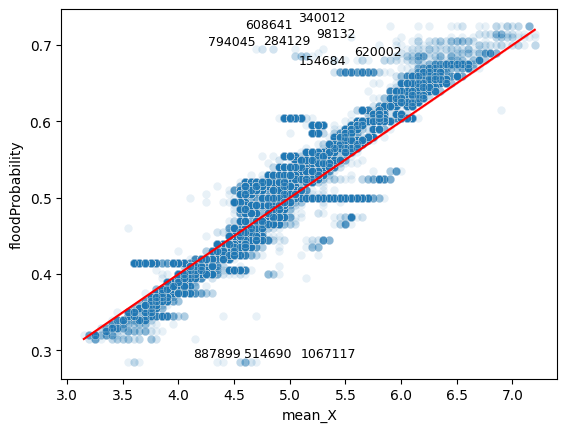

In [13]:
from adjustText import adjust_text

mean_X = train.drop(columns='FloodProbability').mean(axis=1)
prediction_df = pd.DataFrame({
        'mean_X': mean_X,
        'floodProbability': train['FloodProbability'],
        'prediction': mean_X * 0.1
    })
prediction_df['differences'] = abs(prediction_df['prediction'] - prediction_df['floodProbability'])

sns.scatterplot(data=prediction_df, x='mean_X', y='floodProbability', alpha=0.1)
sns.lineplot(data=prediction_df, x='mean_X', y= 'prediction', color='red')

top_differences = prediction_df.nlargest(10, 'differences')
texts = []
for idx, row in top_differences.iterrows():
    text = plt.text(row['mean_X'], row['floodProbability'], f"{idx}", fontsize=9, color='black')
    texts.append(text)
adjust_text(texts)

plt.show()

In [19]:
train.iloc[prediction_df.nlargest(10, 'differences').index].apply(lambda row : row[:-1].std(), axis=1)

794045     1.657519
340012     1.585294
608641     2.403397
98132      2.700390
284129     2.518876
620002     2.502104
1067117    2.273416
514690     2.833540
887899     2.641272
154684     2.258901
dtype: float64

# 2. Would KNN work? How close are things

- Are all the vals different? Does this mean our test is all dif?

In [29]:
print("Train rows:", len(train))
print("Train unique:", len(train.drop(columns='FloodProbability').drop_duplicates()))

print("Test rows:", len(test))
print("Test unique:", len(test.drop(columns='FloodProbability', errors='ignore').drop_duplicates()))

combined = pd.concat([train, test], axis=0)

print("Combined rows:", len(combined))
print("Combined unique:", len(combined.drop(columns='FloodProbability', errors='ignore').drop_duplicates()))

Train rows: 1117957
Train unique: 1117957
Test rows: 745305
Test unique: 745305
Combined rows: 1863262
Combined unique: 1863262


In [36]:
X_train, X_test, y_train, y_test = \
    train_test_split(train.drop(columns='FloodProbability'), train['FloodProbability'], test_size=0.1, random_state=42)

knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1)

In [38]:
# Parameters
batch_size = 100  # Adjust based on your data and system capabilities
n_batches = len(X_test) // batch_size + (1 if len(X_test) % batch_size != 0 else 0)

# Initialize variables to store cumulative predictions and true values
y_pred_cumulative = []
y_true_cumulative = []

# Predict in batches and print R^2 scores along the way
for i in range(n_batches):
    # Get the current batch of test data
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_test))
    
    batch_X = X_test[start_idx:end_idx]
    batch_y = y_test[start_idx:end_idx]
    
    # Predict for the current batch
    y_pred_batch = knn.predict(batch_X)
    
    # Append the predictions and true values to the cumulative lists
    y_pred_cumulative.extend(y_pred_batch)
    y_true_cumulative.extend(batch_y)
    
    # Compute the R^2 score for this batch
    r2 = r2_score(y_true_cumulative, y_pred_cumulative)
    
    # Print the R^2 score at this point
    print(f"Batch {i + 1}/{n_batches} - R^2 score: {r2:.4f}")

# Final R^2 score after all batches
final_r2 = r2_score(y_true_cumulative, y_pred_cumulative)
print(f"Final R^2 score: {final_r2:.4f}")


Batch 1/1118 - R^2 score: 0.5430
Batch 2/1118 - R^2 score: 0.2860
Batch 3/1118 - R^2 score: 0.2755
Batch 4/1118 - R^2 score: 0.2841
Batch 5/1118 - R^2 score: 0.3218
Batch 6/1118 - R^2 score: 0.3190
Batch 7/1118 - R^2 score: 0.3352
Batch 8/1118 - R^2 score: 0.3176
Batch 9/1118 - R^2 score: 0.3340
Batch 10/1118 - R^2 score: 0.3604
Batch 11/1118 - R^2 score: 0.3531
Batch 12/1118 - R^2 score: 0.3598
Batch 13/1118 - R^2 score: 0.3804
Batch 14/1118 - R^2 score: 0.3949
Batch 15/1118 - R^2 score: 0.3958
Batch 16/1118 - R^2 score: 0.3816
Batch 17/1118 - R^2 score: 0.3765
Batch 18/1118 - R^2 score: 0.3667
Batch 19/1118 - R^2 score: 0.3613
Batch 20/1118 - R^2 score: 0.3644
Batch 21/1118 - R^2 score: 0.3631
Batch 22/1118 - R^2 score: 0.3571
Batch 23/1118 - R^2 score: 0.3505
Batch 24/1118 - R^2 score: 0.3560
Batch 25/1118 - R^2 score: 0.3550
Batch 26/1118 - R^2 score: 0.3630
Batch 27/1118 - R^2 score: 0.3598
Batch 28/1118 - R^2 score: 0.3643
Batch 29/1118 - R^2 score: 0.3647
Batch 30/1118 - R^2 sco

KeyboardInterrupt: 

So, 1NN dogshit

But what about KNN, and then adjusting own prediction based on dist. to neighbors vals?

In [54]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

# Fit the KNN model
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

# Prediction function with adjustment
def predict_with_adjustment(knn, X_test, y_test, adjustment_factor=0.1):
    y_pred_cumulative = []
    y_true_cumulative = []

    for i in range(len(X_test)):
        test_row = X_test[i:i+1]  # Current row for prediction
        true_value = y_test.iloc[i]
        # print(test_row, true_value)

        # Get the prediction using KNN
        y_pred = knn.predict(test_row)[0]
        # print("y prediction:", y_pred)

        # Find the k-nearest neighbors (for 1-NN, it is just the closest neighbor)
        neighbors = knn.kneighbors(test_row, return_distance=False)
        # print("neighbors", neighbors)

        # Get the feature values of the nearest neighbor (cluster center for 1-NN)
        neighbor_center = X_train.iloc[neighbors[0]].mean(axis=0).mean()
        # print("neighbor center", neighbor_center)

        # Calculate the average of the test row
        test_row_avg = test_row.mean(axis=1).values
        # print("test row avg", test_row_avg)

        # Compute the difference between the averages
        difference = test_row_avg - neighbor_center
        # print("diff", difference)

        # Adjust the prediction by adding 0.1 * the difference
        adjusted_pred = y_pred + adjustment_factor * np.sum(difference)

        # print("initial pred:", y_pred)
        # print("adjusted pred:", adjusted_pred)
        # print("actual value:", true_value)

        # Store predictions and true values for later R^2 calculation
        y_pred_cumulative.append(adjusted_pred)
        y_true_cumulative.append(true_value)

        # Print R^2 score after each batch (optional)
        r2 = r2_score(y_true_cumulative, y_pred_cumulative)
        print(f"R^2 score: {r2:.4f}")

    # Final R^2 score
    final_r2 = r2_score(y_true_cumulative, y_pred_cumulative)
    print(f"Final R^2 score: {final_r2:.4f}")

    return np.array(y_pred_cumulative)

# Make predictions with adjustment
y_pred_adjusted = predict_with_adjustment(knn, X_test, y_test)


/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


R^2 score: nan
R^2 score: -4.0617
R^2 score: 0.7110
R^2 score: 0.6864
R^2 score: 0.7800
R^2 score: 0.8786
R^2 score: 0.9158
R^2 score: 0.8877
R^2 score: 0.9420
R^2 score: 0.9473
R^2 score: 0.9432
R^2 score: 0.9432
R^2 score: 0.9201
R^2 score: 0.8642
R^2 score: 0.8605
R^2 score: 0.8688
R^2 score: 0.8747
R^2 score: 0.8739
R^2 score: 0.8757
R^2 score: 0.8800
R^2 score: 0.8765
R^2 score: 0.8777
R^2 score: 0.8780
R^2 score: 0.8753
R^2 score: 0.8531
R^2 score: 0.8596
R^2 score: 0.8652
R^2 score: 0.8684
R^2 score: 0.8999
R^2 score: 0.9029
R^2 score: 0.9051
R^2 score: 0.9045
R^2 score: 0.9062
R^2 score: 0.9019
R^2 score: 0.8915
R^2 score: 0.8914
R^2 score: 0.8820
R^2 score: 0.8838
R^2 score: 0.8847
R^2 score: 0.8802
R^2 score: 0.8761
R^2 score: 0.8695
R^2 score: 0.8696
R^2 score: 0.8538
R^2 score: 0.8525
R^2 score: 0.8519
R^2 score: 0.8520
R^2 score: 0.8504
R^2 score: 0.8605
R^2 score: 0.8606
R^2 score: 0.8635
R^2 score: 0.8635
R^2 score: 0.8629
R^2 score: 0.8629
R^2 score: 0.8571
R^2 score: 0

KeyboardInterrupt: 